In [1]:
from pyteomics.mass.mass import nist_mass
import os
import pandas as pd
import heapq
from Chemometrics.import_common import *
%matplotlib inline

# 状态定义 {state: value}
    状态转移

In [2]:
def topk_dict(_dict, k=5):
    """
    _dict中key最大的k个
    """
    dict_ = {m: _dict[m] for m in 
             heapq.nlargest(k, _dict, key=_dict.get)}
    return dict_

In [3]:
def filter_nist(isotopes, threshold=1e-4):
    """
    过滤prob小于threshold（1e-4）的元素同位素
    """
    
    _isotopes ={isotopes[m] for m in  isotopes if m > 0 and isotopes[m][1]>threshold}
    return _isotopes

In [4]:
def iso_dist(composition, k=100, ethresshold=1e-5):
    """
    计算同位素分布
    """
    _nist_mass = {el: filter_nist(nist_mass[el], threshold=ethresshold) 
                  for el in nist_mass if el in composition}
    # state: value = {mass: prob}
    new_states = {0: 1}
    for e in composition: #元素组
        isotopes = _nist_mass[e]
        for ei in range(composition[e]): #元素组内
            # 开始状态转移
            if k is not None:
                states = topk_dict(new_states, k=k)
            else:
                states = new_states
            new_states = {}
            for state in states:
                for _mass, _prob in isotopes: #同位素
                    if state + _mass in new_states:
                        new_states[state + _mass] += states[state] * _prob #状态转移
                    else:
                        new_states[state + _mass] = states[state] * _prob #状态转移
    states = topk_dict(new_states, k=k)
    return states

In [124]:
%%time
_composition = {'C':100, 'H':200, 'O': 2, 'S':20}
a = iso_dist(_composition)

Wall time: 162 ms


In [125]:
_a = pd.Series(a).reset_index().sort_values('index')
b = _a.loc[:, 'index']
_by = (b.diff()>1e-3).cumsum()

In [126]:
c = _a.groupby(_by).agg({'index': np.mean, 0: np.sum})
c.columns = ['mz', 'prob']
c

,mz,prob
index,,
0,2072.996256,0.118647
1,2073.995643,0.018736
2,2074.000042,0.128416
3,2074.002532,0.002729
4,2074.992052,0.106169
5,2074.995031,0.001405
6,2074.998998,0.020264
7,2075.000502,0.000488
8,2075.001920,0.000431


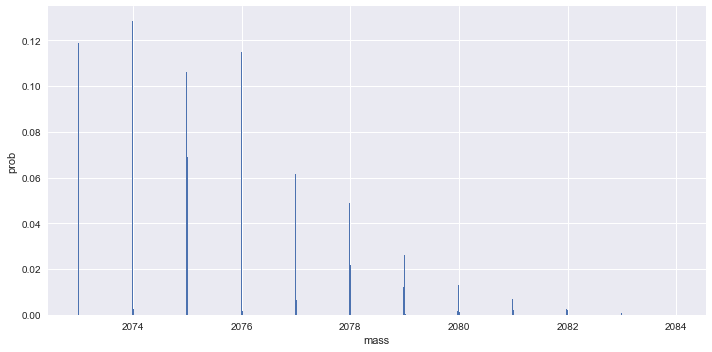

In [128]:
plt.figure(figsize=(10,5))
plt.bar(c.mz, c.prob, width=.02)
plt.xlabel('mass')
plt.ylabel('prob')
plt.tight_layout()
plt.savefig('C100H200O2S20.png', dpi=300)

In [7]:
_nist_mass = {el: filter_nist(nist_mass[el], threshold=1e-5) 
                  for el in nist_mass if el in _composition}

In [45]:
compositions = pd.read_excel('./isotopes/TW80分子式(1).xlsx').to_dict(orient='record')

F的长度为(100,),占比为0.9986821838961887


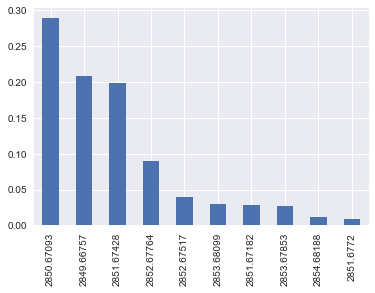

In [94]:
F = pd.Series(iso_dist(compositions[-1]))
print('F的长度为{},占比为{}'.format(F.shape, F.sum()))
_F = F.groupby(F.index.values.round(5)).sum().sort_values(ascending=False)
_F.head(10).plot.bar()